# Quantum Vision Transformers (Cherrat et al.)

Code to implement the method proposed in ["Quantum Vision Transformers"](https://openreview.net/forum?id=p7xPXoKB0H) by Cherrat et al. The paper ["Quantum Methods for Neural Networks and Application to Medical Image Classification"](https://quantum-journal.org/papers/q-2022-12-22-881/) is also used as a reference.

Unfortunately, the code I have not been able to reproduce the results of the paper. I have tried to contact the authors, but I have not received an answer. If you find any errors, please let me know.

In [1]:
from collections.abc import Sequence

import matplotlib as mpl

import jax
from jax import Array
import jax.numpy as jnp
import flax.linen as nn
jax.config.update("jax_enable_x64", True)

import tensorcircuit as tc
tc.set_dtype("complex128")

from quantum_transformers.datasets import get_mnist_dataloaders
from quantum_transformers.training import train_and_evaluate

data_dir = '/global/cfs/cdirs/m4392/salcc/data'

mpl.rcParams['figure.dpi'] = 50  # To make circuit plots smaller easily
jnp.set_printoptions(linewidth=150)

K = tc.set_backend("jax")

key = jax.random.PRNGKey(0)

def assert_allclose(actual, desired, verbose=True, atol=1e-2):
    if verbose:
        print(actual, desired)
    assert jnp.allclose(actual, desired, atol=atol)

2023-09-01 12:43:53.360953: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-01 12:43:53.360974: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-01 12:43:53.360989: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-01 12:43:56.106693: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Please first ``pip install -U cirq`` to enable related functionality in translation module


## Reconfigurable Beam Splitter (RBS) gate

[0.   +0.j 0.841+0.j 0.54 +0.j 0.   +0.j]


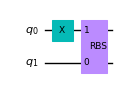

In [2]:
def rbs_gate(theta: float = 0.0):
    theta = tc.gates.num_to_tensor(theta)
    a = tc.cons.backend.cos(theta)
    b = tc.cons.backend.sin(theta)
    unitary = jnp.array([[1, 0, 0, 0], [0, a, b, 0], [0, -b, a, 0], [0, 0, 0, 1]])
    unitary = tc.cons.backend.reshape(unitary, [2, 2, 2, 2])
    return tc.gates.Gate(unitary)

# Register the RBS gate
tc.Circuit.rbs = tc.Circuit.apply_general_variable_gate_delayed(tc.gates.GateVF(rbs_gate, n="RBS"))

c = tc.Circuit(2)
c.x(0)
c.rbs(0, 1, theta=1)
print(jnp.around(c.state(), 3))
c.draw(output='mpl')

## Vector data loaders

In [3]:
n = 8

def normalize(x):
    return x / jnp.linalg.norm(x)

### Diagonal

In [4]:
key, subkey = jax.random.split(key)
x = normalize(jax.random.normal(subkey, (n,)))
print(x)

[ 0.10621358 -0.53976384 -0.14985425 -0.22506401  0.12075178 -0.01747965 -0.51145366  0.58973909]


In [5]:
def get_thetas_diagonal(x):
    # jax.debug.print("x = {}", x)
    thetas = jnp.empty(len(x) - 1)
    acc = 1
    for i in range(len(x) - 1):
        # jax.debug.print("i = {}, acc = {}, x[i] = {}, x[i] / acc = {}, clip = {}, acos = {}",
        #                 i, acc, x[i], x[i] / acc, jnp.clip(x[i] / acc, -1, 1), jnp.arccos(jnp.clip(x[i] / acc, -1, 1)))
        thetas = thetas.at[i].set(jnp.arccos(jnp.clip(x[i] / acc, -1, 1)))
        acc *= jnp.sin(thetas[i])
    return thetas

x_thetas_diagonal = get_thetas_diagonal(x)
print(x_thetas_diagonal)

[1.46438202 2.14460478 1.75122066 1.84830029 1.41736471 1.59318442 2.28522241]


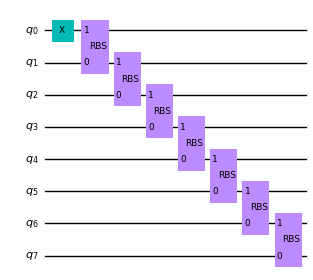

In [6]:
def diagonal_circuit(c: tc.Circuit, q: Sequence[int], t: Array, adjoint: bool = False, pauli_x: bool = False):
    if not adjoint:
        if pauli_x:
            c.x(q[0])
        
        for i in range(len(q) - 1):
            c.rbs(q[i], q[i+1], theta=t[i])
    else:
        for i in reversed(range(len(q) - 1)):
            c.rbs(q[i], q[i+1], theta=-t[i])

        if pauli_x:
            c.x(q[0])
    
    return c.state()

c = tc.Circuit(n)
diagonal_circuit_x_state = diagonal_circuit(c, range(n), x_thetas_diagonal, adjoint=False, pauli_x=True)
c.draw(output='mpl')

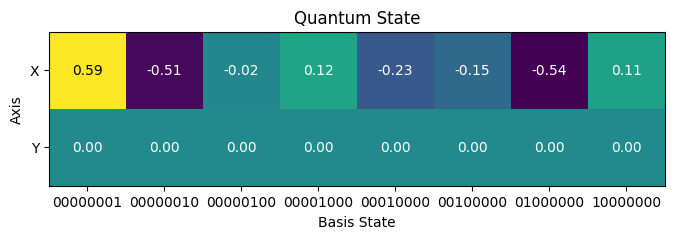

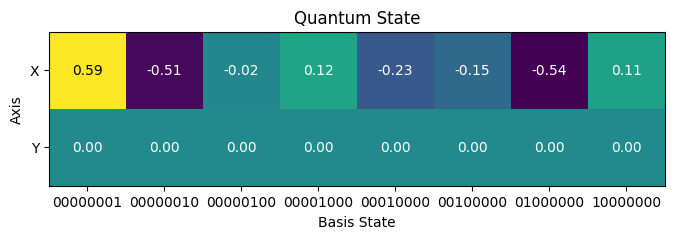

In [7]:
def e(i):
    c = tc.Circuit(len(x))
    c.x(i)
    return c.state()

def get_x_state(x):
    result = 0
    for i in range(len(x)):
        result += x[i] * e(i)
    return result / jnp.linalg.norm(x)

def visualize_quantum_state(state, remove_zero_columns=False):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots(dpi=100, figsize=(8, 2))
    img = np.vstack((state.real, state.imag))
    state_labels = np.array([bin(i)[2:].zfill(int(np.log2(len(state)))) for i in range(len(state))])
    if remove_zero_columns:
        zero_columns = np.any(img, axis=0)
        img = img[:, zero_columns]
        state_labels = state_labels[zero_columns]
    ax.imshow(img)
    ax.set_xticks(range(img.shape[1]))
    ax.set_xticklabels(state_labels)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["X", "Y"])
    ax.set_ylabel("Axis")
    ax.set_xlabel("Basis State")
    ax.set_title("Quantum State")

    for i in range(img.shape[1]):
        for j in range(2):
            ax.text(i, j, f"{img[j, i]:.2f}", ha="center", va="center", color="w" if img[j, i] < 0.25 else "k")

    plt.show()

original_state = get_x_state(x)
visualize_quantum_state(original_state, remove_zero_columns=True)
visualize_quantum_state(diagonal_circuit_x_state, remove_zero_columns=True)
assert_allclose(original_state, diagonal_circuit_x_state, verbose=False)

#### Square inner product

0.06847114674856675 0.06847114674856676


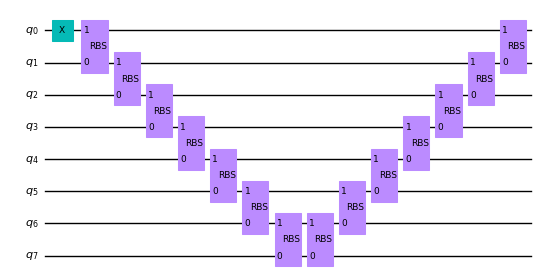

In [8]:
def diagonal_square_inner_product_circuit(c: tc.Circuit, q: Sequence[int], x: Array, w: Array):
    diagonal_circuit(c, q, x, pauli_x=True)
    diagonal_circuit(c, q, w, adjoint=True)
    return 1/2 - 1/2 * c.expectation_ps(z=[q[0]]).real

key, subkey = jax.random.split(key)
w = normalize(jax.random.uniform(subkey, (n,)))
w_thetas_diagonal = get_thetas_diagonal(w)

c = tc.Circuit(n)
result = diagonal_square_inner_product_circuit(c, range(n), x_thetas_diagonal, w_thetas_diagonal)
assert_allclose(result, jnp.dot(x, w)**2)
c.draw(output='mpl')

### Semi-diagonal

In [9]:
# get_thetas_semidiagonal sometimes returns the signs of thetas wrong when x has negative entries, so we use a positive x. TODO: fix this
key, subkey = jax.random.split(key)
x = normalize(jax.random.uniform(subkey, (n,)))
print(x)

[0.25338292 0.19567661 0.41471926 0.56931328 0.49440581 0.26863517 0.21386839 0.19762703]


In [10]:
def get_thetas_semidiagonal(x: Array):
    t = jnp.empty(len(x) - 1)
    t = t.at[1].set(jnp.arctan2(x[0], x[1]))
    t = t.at[-1].set(jnp.arctan2(x[-1], x[-2]))
    m = len(x) // 2 - 1
    for i in range(2, m+1):
        t = t.at[i].set(jnp.arctan2(x[i-1], x[i] * jnp.cos(t[i-1])))
    for i in range(len(x) - 3, m, -1):
        t = t.at[i].set(jnp.arctan2(x[i+1], x[i] * jnp.cos(t[i+1])))
    t = t.at[0].set(jnp.arccos(x[m] / jnp.cos(t[m])))

    thetas = -jnp.ones_like(t)
    thetas = thetas.at[0].set(t[0])
    for i in range(1, len(x)//2):
        thetas = thetas.at[-2*i].set(t[i])
        thetas = thetas.at[-2*i+1].set(t[-i])
    
    return thetas

x_thetas_semidiagonal = get_thetas_semidiagonal(x)
print(x_thetas_semidiagonal)

[0.6861457  0.74389282 0.67555239 0.65740411 0.82567871 0.91320253 0.74594953]


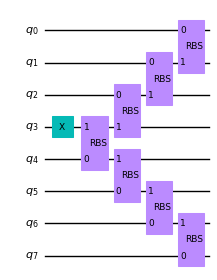

In [11]:
def semidiagonal_circuit(c: tc.Circuit, q: Sequence[int], t: Array, adjoint: bool = False, pauli_x: bool = False):
    m = len(q) // 2 - 1
    
    if not adjoint:
        if pauli_x:
            c.x(q[m])
        
        for i in range(len(q) // 2):
            c.rbs(q[m+i], q[m+i+1], theta=t[2*i])
            if m-i-1 >= 0:
                c.rbs(q[m-i], q[m-i-1], theta=t[2*i+1])
    else:
        for i in reversed(range(len(q) // 2)):
            if m-i-1 >= 0:
                c.rbs(q[m-i], q[m-i-1], theta=-t[2*i+1])
            c.rbs(q[m+i], q[m+i+1], theta=-t[2*i])

        if pauli_x:
            c.x(q[m])
    
    return c.state()

c = tc.Circuit(n)
semidiagonal_circuit_x_state = semidiagonal_circuit(c, range(n), x_thetas_semidiagonal, adjoint=False, pauli_x=True)
c.draw(output='mpl')

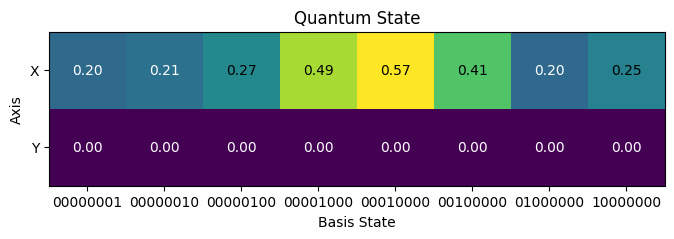

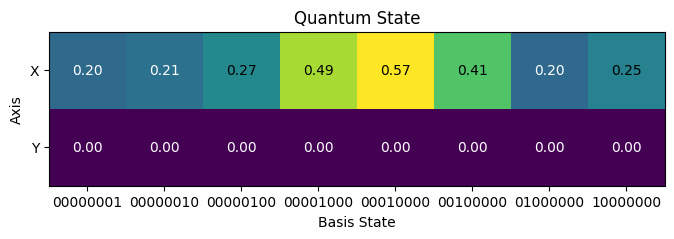

In [12]:
original_state = get_x_state(x)
visualize_quantum_state(original_state, remove_zero_columns=True)
visualize_quantum_state(semidiagonal_circuit_x_state, remove_zero_columns=True)
assert_allclose(original_state, semidiagonal_circuit_x_state, verbose=False)

#### Square inner product

0.7280983321636549 0.7280983321636548


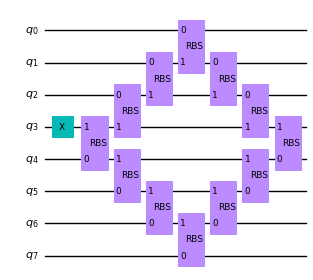

In [13]:
def semidiagonal_square_inner_product_circuit(c: tc.Circuit, q: Sequence[int], x: Array, w: Array, pauli_x: bool = True):
    m = len(q) // 2 - 1
    semidiagonal_circuit(c, q[1:-1], x, pauli_x=pauli_x)
    c.rbs(q[1], q[0], theta=x[-2] - w[-2])
    c.rbs(q[-2], q[-1], theta=x[-1] - w[-1])
    semidiagonal_circuit(c, q[1:-1], w, adjoint=True)
    return 1/2 - 1/2 * c.expectation_ps(z=[q[m]]).real

w_thetas_semidiagonal = get_thetas_semidiagonal(w)

c = tc.Circuit(n)
result = semidiagonal_square_inner_product_circuit(c, range(n), x_thetas_semidiagonal, w_thetas_semidiagonal)
assert_allclose(result, jnp.dot(x, w)**2)
c.draw(output='mpl')

#### Inner product

0.00538119209138338 0.0053811920913834615
0.8532867818990616 0.8532867818990605


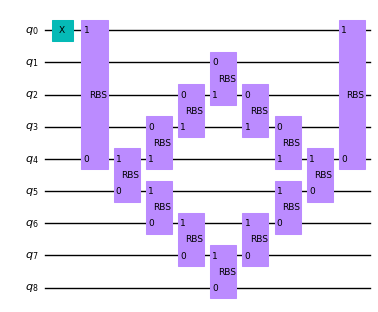

In [14]:
def semidiagonal_inner_product_circuit(c: tc.Circuit, q: Sequence[int], x: Array, w: Array):
    m = (len(q) - 1) // 2
    c.x(q[0])
    c.rbs(q[0], q[m], theta=jnp.pi/4)
    semidiagonal_square_inner_product_circuit(c, q[1:], x, w, pauli_x=False)
    c.rbs(q[0], q[m], theta=jnp.pi/4)
    return 1/2 - 1/2 * c.expectation_ps(z=[q[0]]).real

c = tc.Circuit(n + 1)
result = semidiagonal_inner_product_circuit(c, range(n + 1), x_thetas_semidiagonal, w_thetas_semidiagonal)
assert_allclose(result, (1/2-jnp.dot(x, w)/2)**2)
assert_allclose(1-2*jnp.sqrt(result), jnp.dot(x, w), atol=5e-2)
c.draw(output='mpl')

In [15]:
neg_w_thetas_semidiagonal = get_thetas_semidiagonal(-w)

c = tc.Circuit(n + 1)
result = semidiagonal_inner_product_circuit(c, range(n + 1), x_thetas_semidiagonal, neg_w_thetas_semidiagonal)
assert_allclose(result, (1/2-jnp.dot(x, -w)/2)**2)
assert_allclose(1-2*jnp.sqrt(result), jnp.dot(x, -w), atol=5e-2)

0.8586679739904437 0.8586679739904438
-0.8532867818990602 -0.8532867818990605


In [16]:
key, subkey = jax.random.split(key)
perp_w = jax.random.uniform(subkey, shape=x.shape)
perp_w -= (jnp.dot(perp_w, x) / jnp.dot(x, x)) * x
perp_w = normalize(perp_w)
print(perp_w)
perp_w_thetas_semidiagonal = get_thetas_semidiagonal(perp_w)
print(jnp.dot(x, perp_w), jnp.dot(x, x), jnp.dot(perp_w, perp_w))
print()

# c = tc.Circuit(n + 1)
# result = semidiagonal_inner_product_circuit(c, range(n + 1), x_thetas_semidiagonal, perp_w_thetas_semidiagonal)
# assert_allclose(result, (1/2-jnp.dot(x, perp_w)/2)**2, atol=5e-2)
# assert_allclose(1-2*jnp.sqrt(result), jnp.dot(x, perp_w), atol=5e-2)

[ 0.18441806  0.41664027 -0.28372258 -0.05204872 -0.33260249 -0.13902337  0.5132466   0.56197803]
1.1102230246251565e-16 1.0 1.0



### Parallel

TODO

## Matrix data loaders

TODO

## Orthogonal layers

### Pyramid

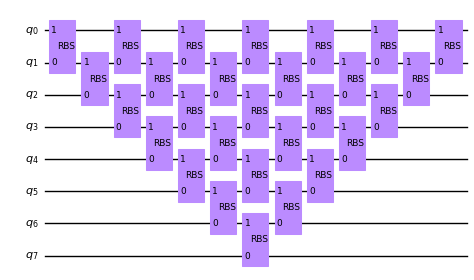

In [17]:
def pyramid_circuit(c: tc.Circuit, q: Sequence[int], t: Array):
    k = 0
    for i in range(len(q)):
        for j in reversed(range(i)):
            c.rbs(q[j], q[j+1], theta=t[k])
            k += 1
    return c

c = tc.Circuit(n)
pyramid_circuit(c, range(n), jnp.empty(n*(n-1)//2))
c.draw(output='mpl')

### X

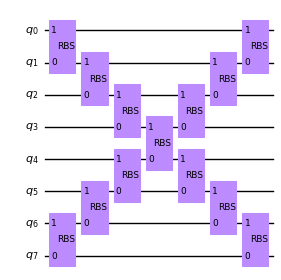

In [18]:
def x_circuit(c: tc.Circuit, q: Sequence[int], t: Array):
    k = 0
    for i in range(1, len(q)):
        c.rbs(q[i-1], q[i], theta=t[k])
        if q[i-1] == q[-i-1] and q[i] == q[-i]:
            continue
        c.rbs(q[-i-1], q[-i], theta=t[k])
        k += 1
    return c

c = tc.Circuit(n)
x_circuit(c, range(n), jnp.empty(2*n-3))
c.draw(output='mpl')

### Butterfly

TODO

## Vision Transformers

### Quantum Orthogonal Patch-Wise Neural Network & Quantum Orthogonal Transformer

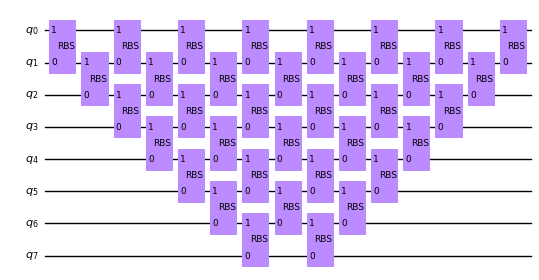

In [19]:
def orthogonal_patchwise_neural_network_circuit(c: tc.Circuit, q: Sequence[int], xi: Array, t: Array):
    diagonal_circuit(c, q, xi)
    pyramid_circuit(c, q, t)
    return c

c = tc.Circuit(n)
c = orthogonal_patchwise_neural_network_circuit(c, range(n), jnp.empty(n), jnp.empty(n*(n-1)//2))
c.draw(output='mpl')

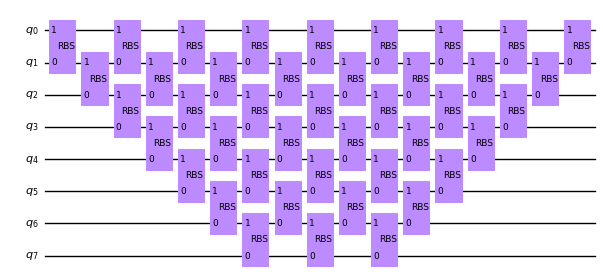

In [20]:
def orthogonal_transformer_attention_circuit(c: tc.Circuit, q: Sequence[int], xi: Array, t: Array, xj: Array):
    diagonal_circuit(c, q, xi)
    pyramid_circuit(c, q, t)
    diagonal_circuit(c, q, xj, adjoint=True)
    return c

c = tc.Circuit(n)
c = orthogonal_transformer_attention_circuit(c, range(n), jnp.empty(n), jnp.empty(n*(n-1)//2), jnp.empty(n))
c.draw(output='mpl')

In [21]:
# Example function that operates on a pair of 1D vectors and an additional parameter and returns a scalar
def f(a, b, c):
    return jnp.dot(a, b) / c

# Create a batch of sequences of 1D vectors
batch_sequence = [jnp.array([[1, 2], [3, 4], [5, 6]]),
                  jnp.array([[7, 8], [9, 10], [11, 12]])]

# Convert the batch of sequences of 1D vectors into a single 3D array
batch_sequence_array = jnp.stack(batch_sequence)
print(batch_sequence_array.shape)

# Define the additional parameter that is the same for all batches
c = 2

def manual_vectorized_f(batch_sequence_array, c):
    result = jnp.empty((batch_sequence_array.shape[0], batch_sequence_array.shape[1], batch_sequence_array.shape[1]))
    for b in range(batch_sequence_array.shape[0]):
        for i in range(batch_sequence_array.shape[1]):
            for j in range(batch_sequence_array.shape[1]):
                result = result.at[b, i, j].set(f(batch_sequence_array[b, i], batch_sequence_array[b, j], c))
    return result

def fully_vectorized_f(batch_sequence_array, c):
    vectorized_f = jax.vmap(jax.vmap(jax.vmap(f, in_axes=(0, None, None)), in_axes=(None, 0, None)), in_axes=(0, 0, None))
    return vectorized_f(batch_sequence_array, batch_sequence_array, c)

def batch_vectorized_f(batch_sequence_array, c):
    vectorized_f = jax.vmap(f, in_axes=(0, 0, None))
    result = jnp.empty((batch_sequence_array.shape[0], batch_sequence_array.shape[1], batch_sequence_array.shape[1]))
    for i in range(batch_sequence_array.shape[1]):
        for j in range(batch_sequence_array.shape[1]):
            result = result.at[:, i, j].set(vectorized_f(batch_sequence_array[:, i], batch_sequence_array[:, j], c))
    return result

def optimized_batch_vectorized_f(batch_sequence_array, c):
    def body_fun(carry, inputs):
        i, j = inputs
        result_slice = jax.vmap(f, in_axes=(0, 0, None))(batch_sequence_array[:, i], batch_sequence_array[:, j], c)
        return carry.at[:, i, j].set(result_slice), None

    n = batch_sequence_array.shape[1]
    indices = jnp.array([(i, j) for i in range(n) for j in range(n)])
    result_init = jnp.zeros((batch_sequence_array.shape[0], n, n))
    result, _ = jax.lax.scan(body_fun, result_init, indices)
    return result


# Compute the results
result_manual = manual_vectorized_f(batch_sequence_array, c)
result_full = fully_vectorized_f(batch_sequence_array, c)
result_batch = batch_vectorized_f(batch_sequence_array, c)
result_optimized_batch = optimized_batch_vectorized_f(batch_sequence_array, c)

# Check that all results are equal
assert jnp.allclose(result_full, result_manual)
assert jnp.allclose(result_full, result_batch)
assert jnp.allclose(result_full, result_optimized_batch)

print(result_full.shape)
print(result_full)

(2, 3, 2)
(2, 3, 3)
[[[  2.5   5.5   8.5]
  [  5.5  12.5  19.5]
  [  8.5  19.5  30.5]]

 [[ 56.5  71.5  86.5]
  [ 71.5  90.5 109.5]
  [ 86.5 109.5 132.5]]]


In [22]:
def orthogonal_patchwise_neural_network_circuit_jax(xi_thetas: Array, w: Array):
    n = len(xi_thetas) + 1
    c = tc.Circuit(n)
    q = range(n)
    orthogonal_patchwise_neural_network_circuit(c, q, xi_thetas, w)
    return K.real(jnp.array([c.expectation_ps(z=[i]) for i in q]))

def orthogonal_transformer_attention_circuit_jax(xi_thetas: Array, xj_thetas: Array, w: Array):
    n = len(xi_thetas) + 1
    c = tc.Circuit(n)
    q = range(n)
    orthogonal_transformer_attention_circuit(c, q, xi_thetas, w, xj_thetas)
    return K.real(c.expectation_ps(z=[q[0]]))

class QuantumOrthogonalTransformer(nn.Module):
    patch_size: int
    num_classes: int
    attention: bool = True
    vectorized_attention: bool = True
    hidden_size: int = 16
    num_layers: int = 4
    channels_last: bool = True

    @nn.compact
    def __call__(self, x, train: bool = True):
        assert x.ndim == 4, "Input must be a 4D tensor"

        if not self.channels_last:
            x = x.transpose((0, 3, 1, 2))
        # x.shape = (batch_size, height, width, num_channels)
        # Note that JAX's Conv expects the input to be in the format (batch_size, height, width, num_channels)

        batch_size, height, width, num_channels = x.shape
        assert height == width, "Input must be square"
        img_size = height
        num_patches = (img_size // self.patch_size) ** 2

        # Splitting an image into patches and linearly projecting these flattened patches can be
        # simplified as a single convolution operation, where both the kernel size and the stride size
        # are set to the patch size.
        x = nn.Conv(
            features=self.hidden_size,
            kernel_size=(self.patch_size, self.patch_size),
            strides=self.patch_size,
            padding="VALID"
        )(x)
        # x.shape = (batch_size, sqrt(num_patches), sqrt(num_patches), hidden_size)
        x = jnp.reshape(x, (batch_size, num_patches, self.hidden_size))
        # x.shape = (batch_size, num_patches, hidden_size)

        # Vectorize over the batch dimension and the patch dimension
        x = K.vmap(K.vmap(normalize, vectorized_argnums=0), vectorized_argnums=0)(x)
        x_thetas = K.vmap(K.vmap(get_thetas_diagonal, vectorized_argnums=0), vectorized_argnums=0)(x)
        # x_thetas.shape = (batch_size, num_patches, hidden_size - 1)
        
        # Compute the values
        patch_weights = self.param('V', nn.initializers.normal(), (self.hidden_size * (self.hidden_size - 1) // 2,))
        x = K.vmap(K.vmap(orthogonal_patchwise_neural_network_circuit_jax, vectorized_argnums=0), vectorized_argnums=0)(x_thetas, patch_weights)
        # x.shape = (batch_size, num_patches, hidden_size)

        if self.attention:
            # Compute the attention weights
            attn_weights = self.param('W', nn.initializers.normal(), (self.hidden_size * (self.hidden_size - 1) // 2,))
            if self.vectorized_attention:
                attn = K.vmap(K.vmap(K.vmap(orthogonal_transformer_attention_circuit_jax, vectorized_argnums=0), vectorized_argnums=1), vectorized_argnums=(0, 1))(x_thetas, x_thetas, attn_weights)
            else:
                # attn = jnp.empty((batch_size, num_patches, num_patches))
                # batched = K.vmap(orthogonal_transformer_attention_circuit_jax, vectorized_argnums=(0, 1))
                # for i in range(num_patches):
                #     for j in range(num_patches):
                #         attn = attn.at[:, i, j].set(batched(x_thetas[:, i], x_thetas[:, j], attn_weights))
                def f(carry, inputs):
                    i, j = inputs
                    attn_elem = K.vmap(orthogonal_transformer_attention_circuit_jax, vectorized_argnums=(0, 1))(x_thetas[:, i], x_thetas[:, j], attn_weights)
                    return carry.at[:, i, j].set(attn_elem)
                
                indices = jnp.array([(i, j) for i in range(num_patches) for j in range(num_patches)])
                attn_init = jnp.zeros((batch_size, num_patches, num_patches))
                attn = K.scan(f, indices, attn_init)

            # attn.shape = (batch_size, num_patches, num_patches)
            attn = jnp.sqrt(attn)  # the quantum circuit outputs the square
            attn = nn.softmax(attn, axis=-1)
            # attn.shape = (batch_size, num_patches, num_patches)

            # Compute the weighted sum of the values (context vectors)
            x = jnp.einsum('bij,bjk->bik', attn, x)
            # x.shape = (batch_size, num_patches, hidden_size)

        # Global average pooling
        x = jnp.mean(x, axis=1)
        # x.shape = (batch_size, hidden_size)

        # Classification logits
        x = nn.Dense(features=self.num_classes)(x)
        # x.shape = (batch_size, num_classes)
        return x

In [23]:
x = jnp.ones((64, 28, 28, 3))

patch_wise_neural_network_model = QuantumOrthogonalTransformer(7, 10, attention=False)

key, params_key = jax.random.split(key=key)
variables = patch_wise_neural_network_model.init(params_key, x)
print(jax.tree_map(lambda x: x.shape, variables))

{'params': {'Conv_0': {'bias': (16,), 'kernel': (7, 7, 3, 16)}, 'Dense_0': {'bias': (10,), 'kernel': (16, 10)}, 'V': (120,)}}


In [24]:
# vectorized attention gives out-of-memory error
# not using vectorized attention is (probably) slower, but uses less memory
orthogonal_transformer_model = QuantumOrthogonalTransformer(7, 10, vectorized_attention=False)

key, params_key = jax.random.split(key=key)
variables = orthogonal_transformer_model.init(params_key, x)
print(jax.tree_map(lambda x: x.shape, variables))

{'params': {'Conv_0': {'bias': (16,), 'kernel': (7, 7, 3, 16)}, 'Dense_0': {'bias': (10,), 'kernel': (16, 10)}, 'V': (120,), 'W': (120,)}}


#### Training

In [25]:
# remember that batch_size=32 (with float32) does not fit in 40GB of GPU memory, 16 does with float32, 8 with float64
mnist_train_dataloader, mnist_valid_dataloader, mnist_test_dataloader = get_mnist_dataloaders(batch_size=8, data_dir=data_dir)

In [26]:
jax.config.update('jax_debug_nans', True)

In [27]:
model = QuantumOrthogonalTransformer(7, 10, attention=False)
train_and_evaluate(model, mnist_train_dataloader, mnist_valid_dataloader, mnist_test_dataloader, num_classes=10, num_epochs=5, debug=True)

{'params': {'Conv_0': {'bias': (16,), 'kernel': (7, 7, 1, 16)}, 'Dense_0': {'bias': (10,), 'kernel': (16, 10)}, 'V': (120,)}}


Epoch   1/5:   0%|          | 9/6750 [00:13<41:21,  2.72batch/s]                                                                                                                                                    

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


Epoch   1/5:   0%|          | 9/6750 [00:32<6:45:06,  3.61s/batch]                                                                                                                                                  


FloatingPointError: invalid value (nan) encountered in jit(mul)

In [ ]:
jax.config.update("jax_disable_jit", True)

In [ ]:
model = QuantumOrthogonalTransformer(7, 10, attention=False)
train_and_evaluate(model, mnist_train_dataloader, mnist_valid_dataloader, mnist_test_dataloader, num_classes=10, num_epochs=5, debug=True)

{'params': {'Conv_0': {'bias': (16,), 'kernel': (7, 7, 1, 16)}, 'Dense_0': {'bias': (10,), 'kernel': (16, 10)}, 'V': (120,)}}


Epoch   1/5:   0%|          | 5/6750 [00:50<18:52:50, 10.08s/batch]                                                                                              


FloatingPointError: invalid value (nan) encountered in jit(mul)

### Quantum Compound Transformer

TODO